<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [280]:
import pandas as pd
import psycopg2
import warnings
import matplotlib.pyplot as plt
import requests 
from bs4 import BeautifulSoup
from collections import Counter

# отключить надоедливый warning
warnings.filterwarnings("ignore", category=UserWarning, message="pandas only supports SQLAlchemy connectable")

In [142]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python 
DBNAME = ''
USER = ''
PASSWORD = ''
HOST = ''
PORT = 5432

In [143]:
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [243]:
# текст запроса
query_1 = f'select count(*) from vacancies'

In [244]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_1)

    # Получаем результат
    number_of_vacancies = cur.fetchone()[0]
    print(f'Количество вакансий в базе {number_of_vacancies}')

Количество вакансий в базе 49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [242]:
# текст запроса
query_2 = f'select count(*) from employers'

In [245]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_2)

    # Получаем результат
    number_of_employers = cur.fetchone()[0]
    print(number_of_employers)

23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [241]:
# текст запроса
query_3 = f'select count(*) from areas'

In [246]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_3)

    # Получаем результат
    number_of_areas = cur.fetchone()[0]
    print(number_of_areas)

1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [247]:
# текст запроса
query_4 = f'select count(*) from industries'

In [250]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_4)

    # Получаем результат
    number_of_industries = cur.fetchone()[0]
    print(number_of_industries)

294


***

In [251]:
# выводы по предварительному анализу данных
print(f'''Успешно получено :
Вакансий: {number_of_vacancies}
Pаботодателей: {number_of_employers}
Регионов: { number_of_areas}
Индустрий: {number_of_industries}

Большое количество вакансий указывает на конкуренцию среди работодателей. Также по видимому многие компании открывают сразу несколько вакансий.
Количество индустрий свидетельствует о разнообразии отраслей экономики.
''')

Успешно получено :
Вакансий: 49197
Pаботодателей: 23501
Регионов: 1362
Индустрий: 294

Большое количество вакансий указывает на конкуренцию среди работодателей. Также по видимому многие компании открывают сразу несколько вакансий.
Количество индустрий свидетельствует о разнообразии отраслей экономики.



# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [101]:
# текст запроса
query_5 = '''select areas.name, count(areas.name) as count from vacancies 
inner join areas on vacancies.area_id = areas.id 
group by areas.name
order by count desc'''

In [102]:
# результат запроса
vacancies_area = pd.read_sql_query(query_5, connection)
vacancies_area.head(5)

,name,count
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [112]:
# текст запроса
query6 = '''
    select count(*) 
    from vacancies
    where salary_from is not null or salary_to is not null'''

In [113]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query6)

    # Получаем результат
    number_of_not_empty_records = cur.fetchone()[0]
    print(f'Количество вакансий у которых заполнено хотя бы одно из двух полей с зарплатой: {number_of_not_empty_records}')

Количество вакансий у которых заполнено хотя бы одно из двух полей с зарплатой: 24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [105]:
# текст запроса
query6 = '''
    select *
    from vacancies
    where salary_from is not null or salary_to is not null'''

In [106]:
# результат запроса
vacancies_salary = pd.read_sql_query(query6, connection)
print(f'''Зарплатная вилка:
Cредние значения нижней границы: {round(vacancies_salary['salary_from'].mean())}
Cредние значения верхней границы: {round(vacancies_salary['salary_to'].mean())}''')

Зарплатная вилка:
Cредние значения нижней границы: 71065
Cредние значения верхней границы: 110537


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [107]:
# текст запроса
query7 = '''
    select schedule,employment, count(schedule) as count
    from vacancies
    group by schedule,employment
    order by count desc'''

In [108]:
# результат запроса
vacancies_schedule = pd.read_sql_query(query7, connection)
vacancies_schedule

,schedule,employment,count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [126]:
# текст запроса
query8 = '''
    select experience as "Требуемый опыт работы", count(schedule) as count
    from vacancies
    group by experience
    order by count'''

In [153]:
# результат запроса
vacancies_experience = pd.read_sql_query(query8, connection)
vacancies_experience

,Требуемый опыт работы,count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

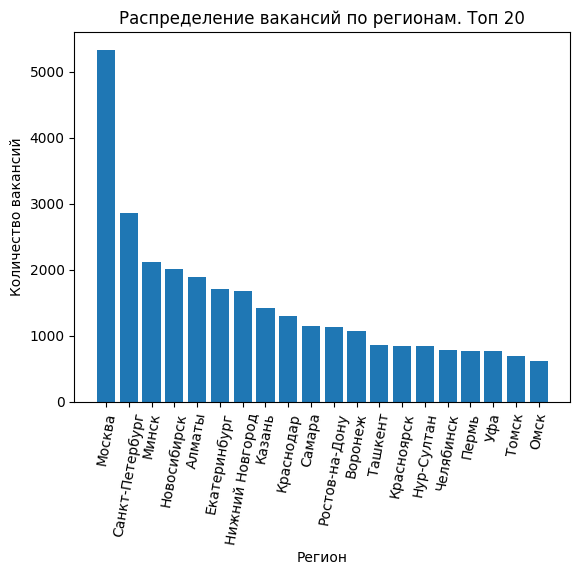

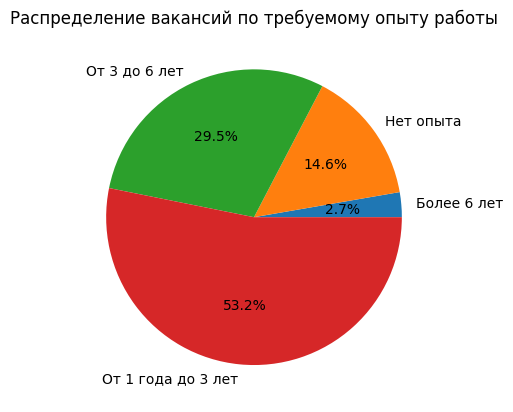

In [154]:
# выводы по детальному анализу вакансий

#Распределение вакансий по регионам. Топ 20
top_20_regions = vacancies_area.head(20)
# Построение столбчатой диаграммы
plt.bar(top_20_regions['name'], top_20_regions['count'])

# Настройка заголовка и меток осей
plt.title('Распределение вакансий по регионам. Топ 20')
plt.xlabel('Регион')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=80)
plt.show()

#Распределение вакансий по требуемому опыту работы
# Построение круговой диаграммы
plt.pie(vacancies_experience['count'], labels=vacancies_experience['Требуемый опыт работы'], autopct='%1.1f%%')

# Настройка заголовка
plt.title('Распределение вакансий по требуемому опыту работы')

# Отображение диаграммы
plt.show()

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [102]:
# текст запроса
query_9 = '''select employers.name, count(employers.name) as count from vacancies 
inner join employers on vacancies.employer_id = employers.id 
group by employers.name
order by count desc'''

In [103]:
# результат запроса
vacancies_employers = pd.read_sql_query(query_9, connection)
vacancies_employers.head()

,name,count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [11]:
# текст запроса. 
# использование вложенного запроса вместо второго join работает быстрее
query_10 = '''
select  
    areas.name AS region,
    count(distinct  employers.id) as employer_count,
    (SELECT COUNT(vacancies.id) FROM vacancies WHERE vacancies.area_id = areas.id) AS vacancy_count
from areas
left join employers on areas.id = employers.area
group by areas.name,areas.id
order by employer_count desc
'''

In [20]:
# результат запроса
areas_employers = pd.read_sql_query(query_10, connection)
display(areas_employers.head(2))

#находим регион в котором наибольшее количество работодателей и нет вакансий.
#из постановки задачи не понял надо было этот фильтр в SQL ставить или реализовавать в DataFrame.
filtered_df = areas_employers[areas_employers['vacancy_count'] == 0] 
result = filtered_df.loc[filtered_df['employer_count'].idxmax()]

print(f"Регион в котором наибольшее количество работодателей и нет вакансий: {result['region']}")


,region,employer_count,vacancy_count
0,Москва,5864,5333
1,Санкт-Петербург,2217,2851


Регион в котором наибольшее количество работодателей и нет вакансий Россия


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [111]:
# текст запроса
query_11 = '''select  count(distinct area_id) as areas_count,
employer_id AS employer  
from vacancies
group BY employer
order by areas_count desc'''

In [24]:
# результат запроса
employer_vacancies_area = pd.read_sql_query(query_11, connection)
employer_vacancies_area.head()

,areas_count,employer
0,181,1740
1,152,2748
2,116,5724811
3,88,5130287
4,71,3682876


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [25]:
# текст запроса
query_12 = '''
select count(*)
from(
    select id as employer_id
    from employers
    except
    select employer_id
    from employers_industries
) as result '''

In [28]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_12)

    # Получаем результат
    result = cur.fetchone()[0]
    print(f'Количество работодателей, у которых не указана сфера деятельности {result}')

Количество работодателей, у которых не указана сфера деятельности 8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [29]:
# текст запроса
query_13 = '''select  employers.name, employers.id, count(inds.name) as inds_count
from employers
inner join employers_industries as ei on employers.id = ei.employer_id
inner join industries as inds on ei.industry_id = inds.id
group by employers.name, employers.id
having count(inds.name) = 4
order by employers.name
limit 1 offset 2 '''

In [33]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_13)

    # Получаем результат
    result = cur.fetchone()[0]
    print(f'''Название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, 
у которых указано четыре сферы деятельности: {result}''')

Название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, 
у которых указано четыре сферы деятельности: 2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [36]:
# текст запроса
query_14 = '''select count(distinct ei.employer_id) 
from industries as i
inner join employers_industries as ei on i.id = ei.industry_id
where i.name = 'Разработка программного обеспечения'
group by i.name'''

In [58]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_14)

    # Получаем результат
    result = cur.fetchone()[0]
    print(f'''У {result} работодателей в качестве сферы деятельности указана "Разработка программного обеспечения"''')

У 3553 работодателей в качестве сферы деятельности указана "Разработка программного обеспечения"


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [59]:
# код для получения списка городов-милионников

url = "https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8" 

# Загрузить HTML-страницу
response = requests.get(url)
response.raise_for_status()  # Проверка на наличие ошибок при запросе

# Парсинг HTML с использованием BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Найти таблицу с классом "standard sortable"
table = soup.find('table', {'class': 'standard sortable'})

# Извлечь заголовок второго столбца
headers = [th.text.strip() for th in table.find_all('th')]
second_column_header = headers[1]

# Извлечь данные второго столбца
second_column_data = []
for row in table.find_all('tr')[1:]:  # Пропустить заголовок таблицы
    cols = row.find_all('td')
    if len(cols) > 1:  
        second_column_data.append(cols[1].text.strip())

# Создать DataFrame с только вторым столбцом
cities_of_millions = pd.DataFrame({second_column_header: second_column_data})
cities_of_millions.head(2)


,Город
0,Москва
1,Санкт-Петербург


In [101]:
# текст запроса

# преобразовать список городов в формат строки для SQL-запроса
cities_list = cities_of_millions['Город'].apply(lambda x: f"'{x}'").tolist()
cities_str = ', '.join(cities_list)

query_15 = f'''
with av as (select a.name as город , count(a.name) as count
from employers as e
inner join vacancies as v on e.id = v.employer_id
inner join areas as a on v.area_id = a.id
where e.name = 'Яндекс'
group by город 
order by count) 

select город, count
from av
where город in ({cities_str})

union all

select 'Total' AS город, SUM(count) AS count
from av
where город in ({cities_str});
'''

In [100]:
# результат запроса
yandex_stat = pd.read_sql_query(query_15, connection)
yandex_stat


,город,count
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Пермь,25.0
5,Казань,25.0
6,Ростов-на-Дону,25.0
7,Уфа,26.0
8,Самара,26.0
9,Краснодар,30.0


***

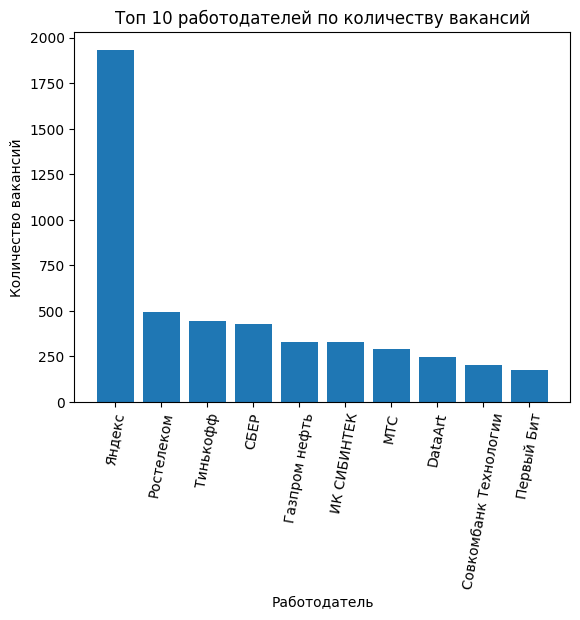

In [104]:
# выводы по анализу работодателей

#Топ 10 работодателей по количеству вакансий
top_10_employers = vacancies_employers.head(10)
# Построение столбчатой диаграммы
plt.bar(top_10_employers['name'], top_10_employers['count'])

# Настройка заголовка и меток осей
plt.title('Топ 10 работодателей по количеству вакансий')
plt.xlabel('Работодатель')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=80)
plt.show()




# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [108]:
# текст запроса
query_16 = f'''
select 	count(*)
from vacancies
where name ilike '%data%' or name ilike '%данн%'
'''

In [258]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_16)

    # Получаем результат
    ds_vacancies_count = cur.fetchone()[0]
    print(f'Вакансий имеющих отношение к данным: {ds_vacancies_count}')

Вакансий имеющих отношение к данным: 1771


2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [260]:
# текст запроса
query_17 = '''
select count(*)
from vacancies
where 	(name ilike '%data scientist%' or 
		 name ilike '%data science%' or 
		 name ilike '%исследователь данных%' or 
		(name ilike '%ml%' and name not ilike '%html%') or
		 name ilike '%machine learning%' or 
		 name ilike '%машинн%обучен%') and
		(name ilike '%junior%' or
		 experience ilike '%нет опыта%' or
		 employment ilike '%стажировка%')'''

In [261]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_17)

    # Получаем результат
    junior_ds_vacancy_cnt = cur.fetchone()[0]
    print(f'Подходящих вакансий для начинающего дата-сайентиста: {junior_ds_vacancy_cnt}')

Подходящих вакансий для начинающего дата-сайентиста: 51


3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [265]:
# текст запроса
query_18 = '''
select count(*)
from vacancies
where 	(name ilike '%data scientist%' or 
		 name ilike '%data science%' or 
		 name ilike '%исследователь данных%' or 
		(name ilike '%ml%' and name not ilike '%html%') or
		 name ilike '%machine learning%' or 
		 name ilike '%машинн%обучен%') and
		(key_skills like '%SQL%' or
		 key_skills like '%postgres%')'''

In [266]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_18)

    # Получаем результат
    db_skill_cnt = cur.fetchone()[0]
    print(f'Вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres: {db_skill_cnt}')

Вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres: 229


4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [263]:
# текст запроса
query_19 = '''
select count(*)
from vacancies
where 	(name ilike '%data scientist%' or 
		 name ilike '%data science%' or 
		 name ilike '%исследователь данных%' or 
		(name ilike '%ml%' and name not ilike '%html%') or
		 name ilike '%machine learning%' or 
		 name ilike '%машинн%обучен%') and
		(key_skills ilike '%Python%')'''

In [264]:
# результат запроса
with connection.cursor() as cur:
    # Выполняем запрос
    cur.execute(query_19)

    # Получаем результат
    pyhton_skill_cnt = cur.fetchone()[0]
    print(f'Количество вакансий, в которых в качестве ключевого навыка указан Python: {pyhton_skill_cnt}')

Количество вакансий, в которых в качестве ключевого навыка указан Python: 357


5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [225]:
# текст запроса
query_20 = '''
select key_skills
from vacancies
where 	(name ilike '%data scientist%' or 
		 name ilike '%data science%' or 
		 name ilike '%исследователь данных%' or 
		(name like '%ML%' and name not ilike '%HTML%') or
		 name ilike '%machine learning%' or 
		 name ilike '%машинн%обучен%') 
         and (key_skills is not null)'''

In [269]:
# результат запроса
ds_vacansies = pd.read_sql_query(query_20, connection)

#добавить атрибут количество навыков
ds_vacansies['skills_count'] = ds_vacansies['key_skills'].apply(lambda x: len(str(x).split('\t')))

print(f"В вакансиях для DS ключевых навыков в среднем указывают: {ds_vacansies['skills_count'].mean():.2f}")

В вакансиях для DS ключевых навыков в среднем указывают: 6.41


6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [227]:
# текст запроса
query_21 = '''
select experience,
    round(avg(coalesce((salary_from + salary_to) / 2, salary_from, salary_to)),0)  AS average_salary
FROM vacancies
WHERE (name ilike '%data scientist%' or 
		 name ilike '%data science%' or 
		 name ilike '%исследователь данных%' or 
		(name like '%ML%' and name not like '%HTML%') or
		 name ilike '%machine learning%' or 
		 name ilike '%машинн%обучен%') 
         and (salary_from is not null or salary_to is not null)
GROUP BY experience;'''

In [267]:
# результат запроса
ds_salary = pd.read_sql_query(query_21, connection)
ds_mean_salary = int(ds_salary[ds_salary['experience']=='От 3 до 6 лет']['average_salary'].iloc[0])
print(f'''В среднем дата-сайентист с опытом работы от 3 до 6 лет может рассчитывать на зарплату: {ds_mean_salary}''')

В среднем дата-сайентист с опытом работы от 3 до 6 лет может рассчитывать на зарплату: 243115


***

In [272]:
# выводы по предметному анализу
print('''
Несмотря большое количество вакансий с умениями дата-сайентиста - 1771, спроса на начинающих  дата-сайентистов почти нет , всего 51 вакансия.
Также наблюдается более высокая востребованность в умениях работать с Python нежели c БД.
Большую роль играет количество навыков требуемых работодателем.
        ''')

print(f'Вакансий имеющих отношение к данным: {ds_vacancies_count}')
print(f'Подходящих вакансий для начинающего дата-сайентиста: {junior_ds_vacancy_cnt}')
print(f'Количество вакансий, в которых в качестве ключевого навыка указан Python: {pyhton_skill_cnt}')
print(f'Вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres: {db_skill_cnt}')
print(f'В среднем дата-сайентист с опытом работы от 3 до 6 лет может рассчитывать на зарплату: {ds_mean_salary}')
print(f"В вакансиях для DS ключевых навыков в среднем указывают: {ds_vacansies['skills_count'].mean():.2f}")





Несмотря большое количество вакансий с умениями дата-сайентиста - 1771, спроса на начинающих  дата-сайентистов почти нет , всего 51 вакансия.
Также наблюдается более высокая востребованность в умениях работать с Python нежели c БД.
Большую роль играет количество навыков требуемых работодателем.
        
Вакансий имеющих отношение к данным: 1771
Подходящих вакансий для начинающего дата-сайентиста: 51
Количество вакансий, в которых в качестве ключевого навыка указан Python: 357
Вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres: 229
В среднем дата-сайентист с опытом работы от 3 до 6 лет может рассчитывать на зарплату: 243115
В вакансиях для DS ключевых навыков в среднем указывают: 6.41


# Общий вывод по проекту

На рынке труда професия дата-сайентиста остается достаточно востребованной. Вакансии есть во всех крупных регионах. 
Наиболее важными атрибутами дата-сайентиста для работодателя является опыт работы и умение работать с Python и SQL.
Количество вакансий для начинающих специалистов в этой области явно оставляет желать лучшего. Возможно это свидетельствует о том что рынок уже вполне наполнен специалистами и пока не готов к новым. 

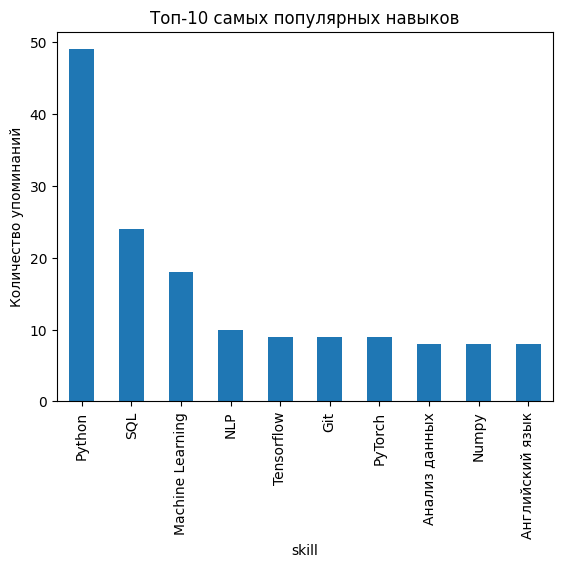

In [286]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования
query = '''select *
FROM vacancies
WHERE (name ilike '%data scientist%' or 
		 name ilike '%data science%' or 
		 name ilike '%исследователь данных%' or 
		(name like '%ML%' and name not like '%HTML%') or
		 name ilike '%machine learning%' or 
		 name ilike '%машинн%обучен%') 
         and (salary_from is not null or salary_to is not null)'''
         
df = pd.read_sql_query(query, connection)

# Удаление NaN и пустых значений 
df['key_skills'] = df['key_skills'].fillna('')

# Разделение и подсчет навыков в каждой вакансии
skills = df['key_skills'].str.split('\t').explode()
skill_counts = Counter(skills)
skills_df = pd.DataFrame(skill_counts.items(), columns=['skill', 'count'])

# выбор топ-10 самых популярных навыков
top_skills = skills_df.sort_values(by='count', ascending=False).head(10)


top_skills.plot(kind='bar', x='skill', y='count', legend=False, title='Топ-10 самых популярных навыков')
plt.ylabel('Количество упоминаний')
plt.show()
 

 Python на данный момент является самым востребованным навыком в вакансиях дата-сейтистов. Вторым по востребованности идет умение работать с БД.

### Распределение зарплат по опыту работы

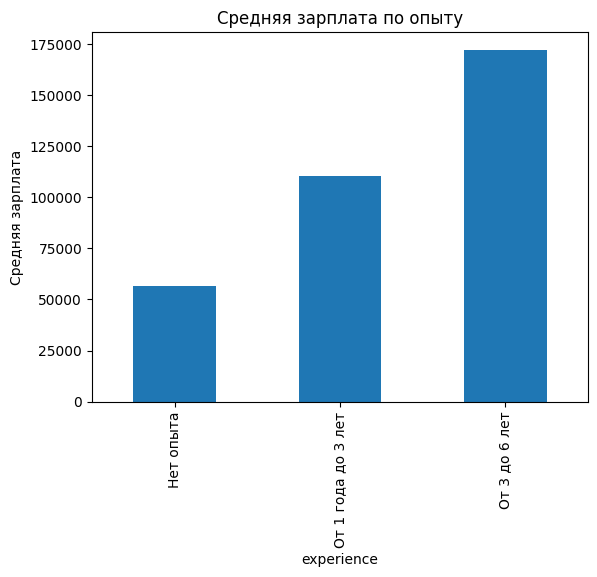

In [283]:
# Заполнение NaN значением 0 в колонках зарплаты для корректных расчетов
df['salary_from'] = df['salary_from'].fillna(0)
df['salary_to'] = df['salary_to'].fillna(0)

# Средняя зарплата
df['average_salary'] = (df['salary_from'] + df['salary_to']) / 2

# Группировка данных по опыту и расчет средней зарплаты
avg_salary_by_experience = df.groupby('experience')['average_salary'].mean()


avg_salary_by_experience.plot(kind='bar', title='Средняя зарплата по опыту', ylabel='Средняя зарплата')
plt.show()

Больше опыта = больше зарплата. тут и добавить нечего.

### Распределение вакансий по типам занятости

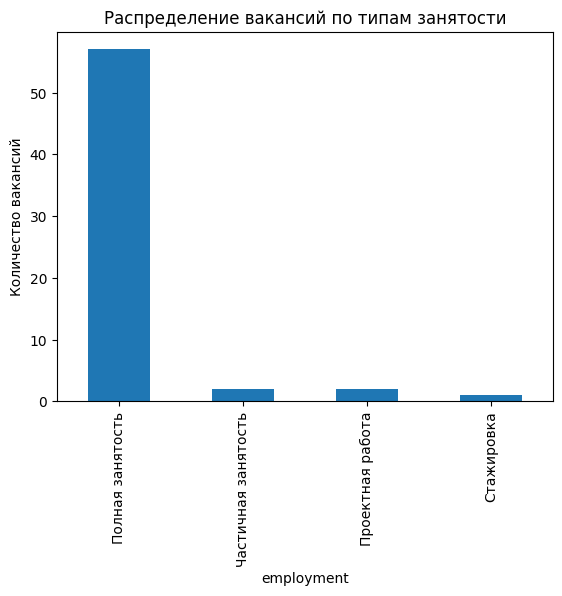

In [278]:
# Группировка данных по типу занятости
employment_counts = df['employment'].value_counts()
    
employment_counts.plot(kind='bar', title='Распределение вакансий по типам занятости', ylabel='Количество вакансий')
plt.show()

Работодатель явно хочет видеть работника в режиме полной занятости. Но несмотря на ето есть и вакансии без нее


###  Анализ типов графика работы и их влияния на зарплату

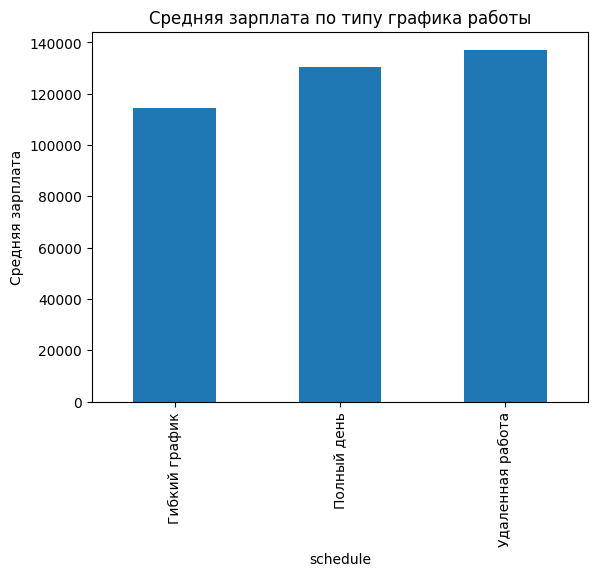

In [284]:
# Группировка данных по типу графика работы и расчет средней зарплаты
avg_salary_by_schedule = df.groupby('schedule')['average_salary'].mean()

avg_salary_by_schedule.plot(kind='bar', title='Средняя зарплата по типу графика работы', ylabel='Средняя зарплата')
plt.show()

Удаленная работа оценивается работодателем выше остальных типов. На втором месте полный рабочний день